# Import Libraries

In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt

# Discriminator Data

In [2]:
# Define real data to feed to discriminator
# In this case, we'll create the data
# data is sin wave

train_data_length = 1024 # number of rows/samples/points
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [3]:
train_data

tensor([[ 2.0995e-01,  2.0841e-01],
        [ 2.6439e+00,  4.7744e-01],
        [ 5.2292e+00, -8.6940e-01],
        ...,
        [ 1.6511e+00,  9.9678e-01],
        [ 1.8992e+00,  9.4657e-01],
        [ 3.0796e-03,  3.0796e-03]])

In [4]:
train_labels

tensor([0., 0., 0.,  ..., 0., 0., 0.])

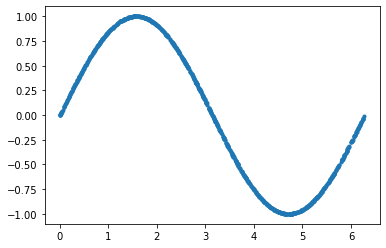

In [5]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
train_loader

# Define Neural Networks

In [7]:
# Define Discriminator Neural Network
# Discriminator is just a binary classifier that tries to learn which data is real (1) and which is fake (0)
# We can use an Advanced CNN network like VGG16 as Discriminator if we want
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 556), # Input Layer - 2 neurons, Hidden Layer - 556 neurons
            nn.ReLU(), # use relu in hidden layer
            nn.Dropout(0.3), # add dropout to hidden layer
            nn.Linear(556, 128), # Hidden Layer 2 - 556 neurons, Hidden Layer 3 - 128 neurons
            nn.Dropout(0.3),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1), 
            nn.Sigmoid(), # output layer gives probabolity of real or fake
        )

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()

In [8]:
# Define Generator Neural Network
# Generator generates data and then checks with Discriminator if it is classified as 0 or 1
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2), # Generator output must have same dimension as Discriminator input. In this case 2
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

# Training

In [9]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss() # Binary Cross Entropy Loss (for two classes - real or fake)

In [10]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        ##################### Data for training the discriminator ###################
        # give all data samples in train_loader as label 1 (real)
        real_samples_labels = torch.ones((batch_size, 1))

        # create random samples and give label 0 (fake)
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))

        # concatenate both data to create final data
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        ##################### Training the discriminator #####################
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ##################### Data for training the generator #####################
        latent_space_samples = torch.randn((batch_size, 2))

        ##################### Training the generator #####################
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        ##################### Show loss #####################
        if epoch % 10 == 0 and n == batch_size - 1:
          print(f"Epoch: {epoch}")
          print(f"Loss D.: {loss_discriminator}")
          print(f"Loss G.: {loss_generator}")
          print('*'*50)

Epoch: 0
Loss D.: 0.2576194405555725
Loss G.: 3.0370025634765625
**************************************************
Epoch: 10
Loss D.: 0.5843027830123901
Loss G.: 0.8879982829093933
**************************************************
Epoch: 20
Loss D.: 0.5860276818275452
Loss G.: 1.383456826210022
**************************************************
Epoch: 30
Loss D.: 0.6625666618347168
Loss G.: 0.7551732063293457
**************************************************
Epoch: 40
Loss D.: 0.5603922009468079
Loss G.: 1.6609838008880615
**************************************************
Epoch: 50
Loss D.: 0.6098954081535339
Loss G.: 0.8504117131233215
**************************************************
Epoch: 60
Loss D.: 0.7456086874008179
Loss G.: 0.6710877418518066
**************************************************
Epoch: 70
Loss D.: 0.7257207036018372
Loss G.: 0.7126896977424622
**************************************************
Epoch: 80
Loss D.: 0.71027672290802
Loss G.: 0.8200652599334717
**

# Testing

In [12]:
# create 500 samples for testing
latent_space_samples = torch.randn(500, 2)

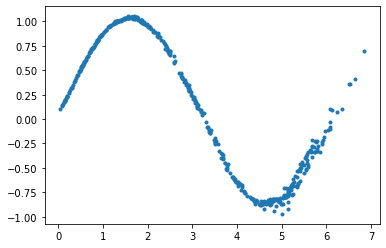

In [13]:
# feed data to generator
# we only need generator for inference
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")